In [21]:
# initialization
import numpy as np
import pandas as pd

# importing Qiskit
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile

# import basic plot tools
from qiskit.visualization import plot_histogram

In [48]:
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        # For large n, use np.random.default_rng for better random integer generation
        rng = np.random.default_rng()
        b = int(rng.integers(1, 2**n))
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle" # To show when we display the circuit
    return oracle_gate

def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

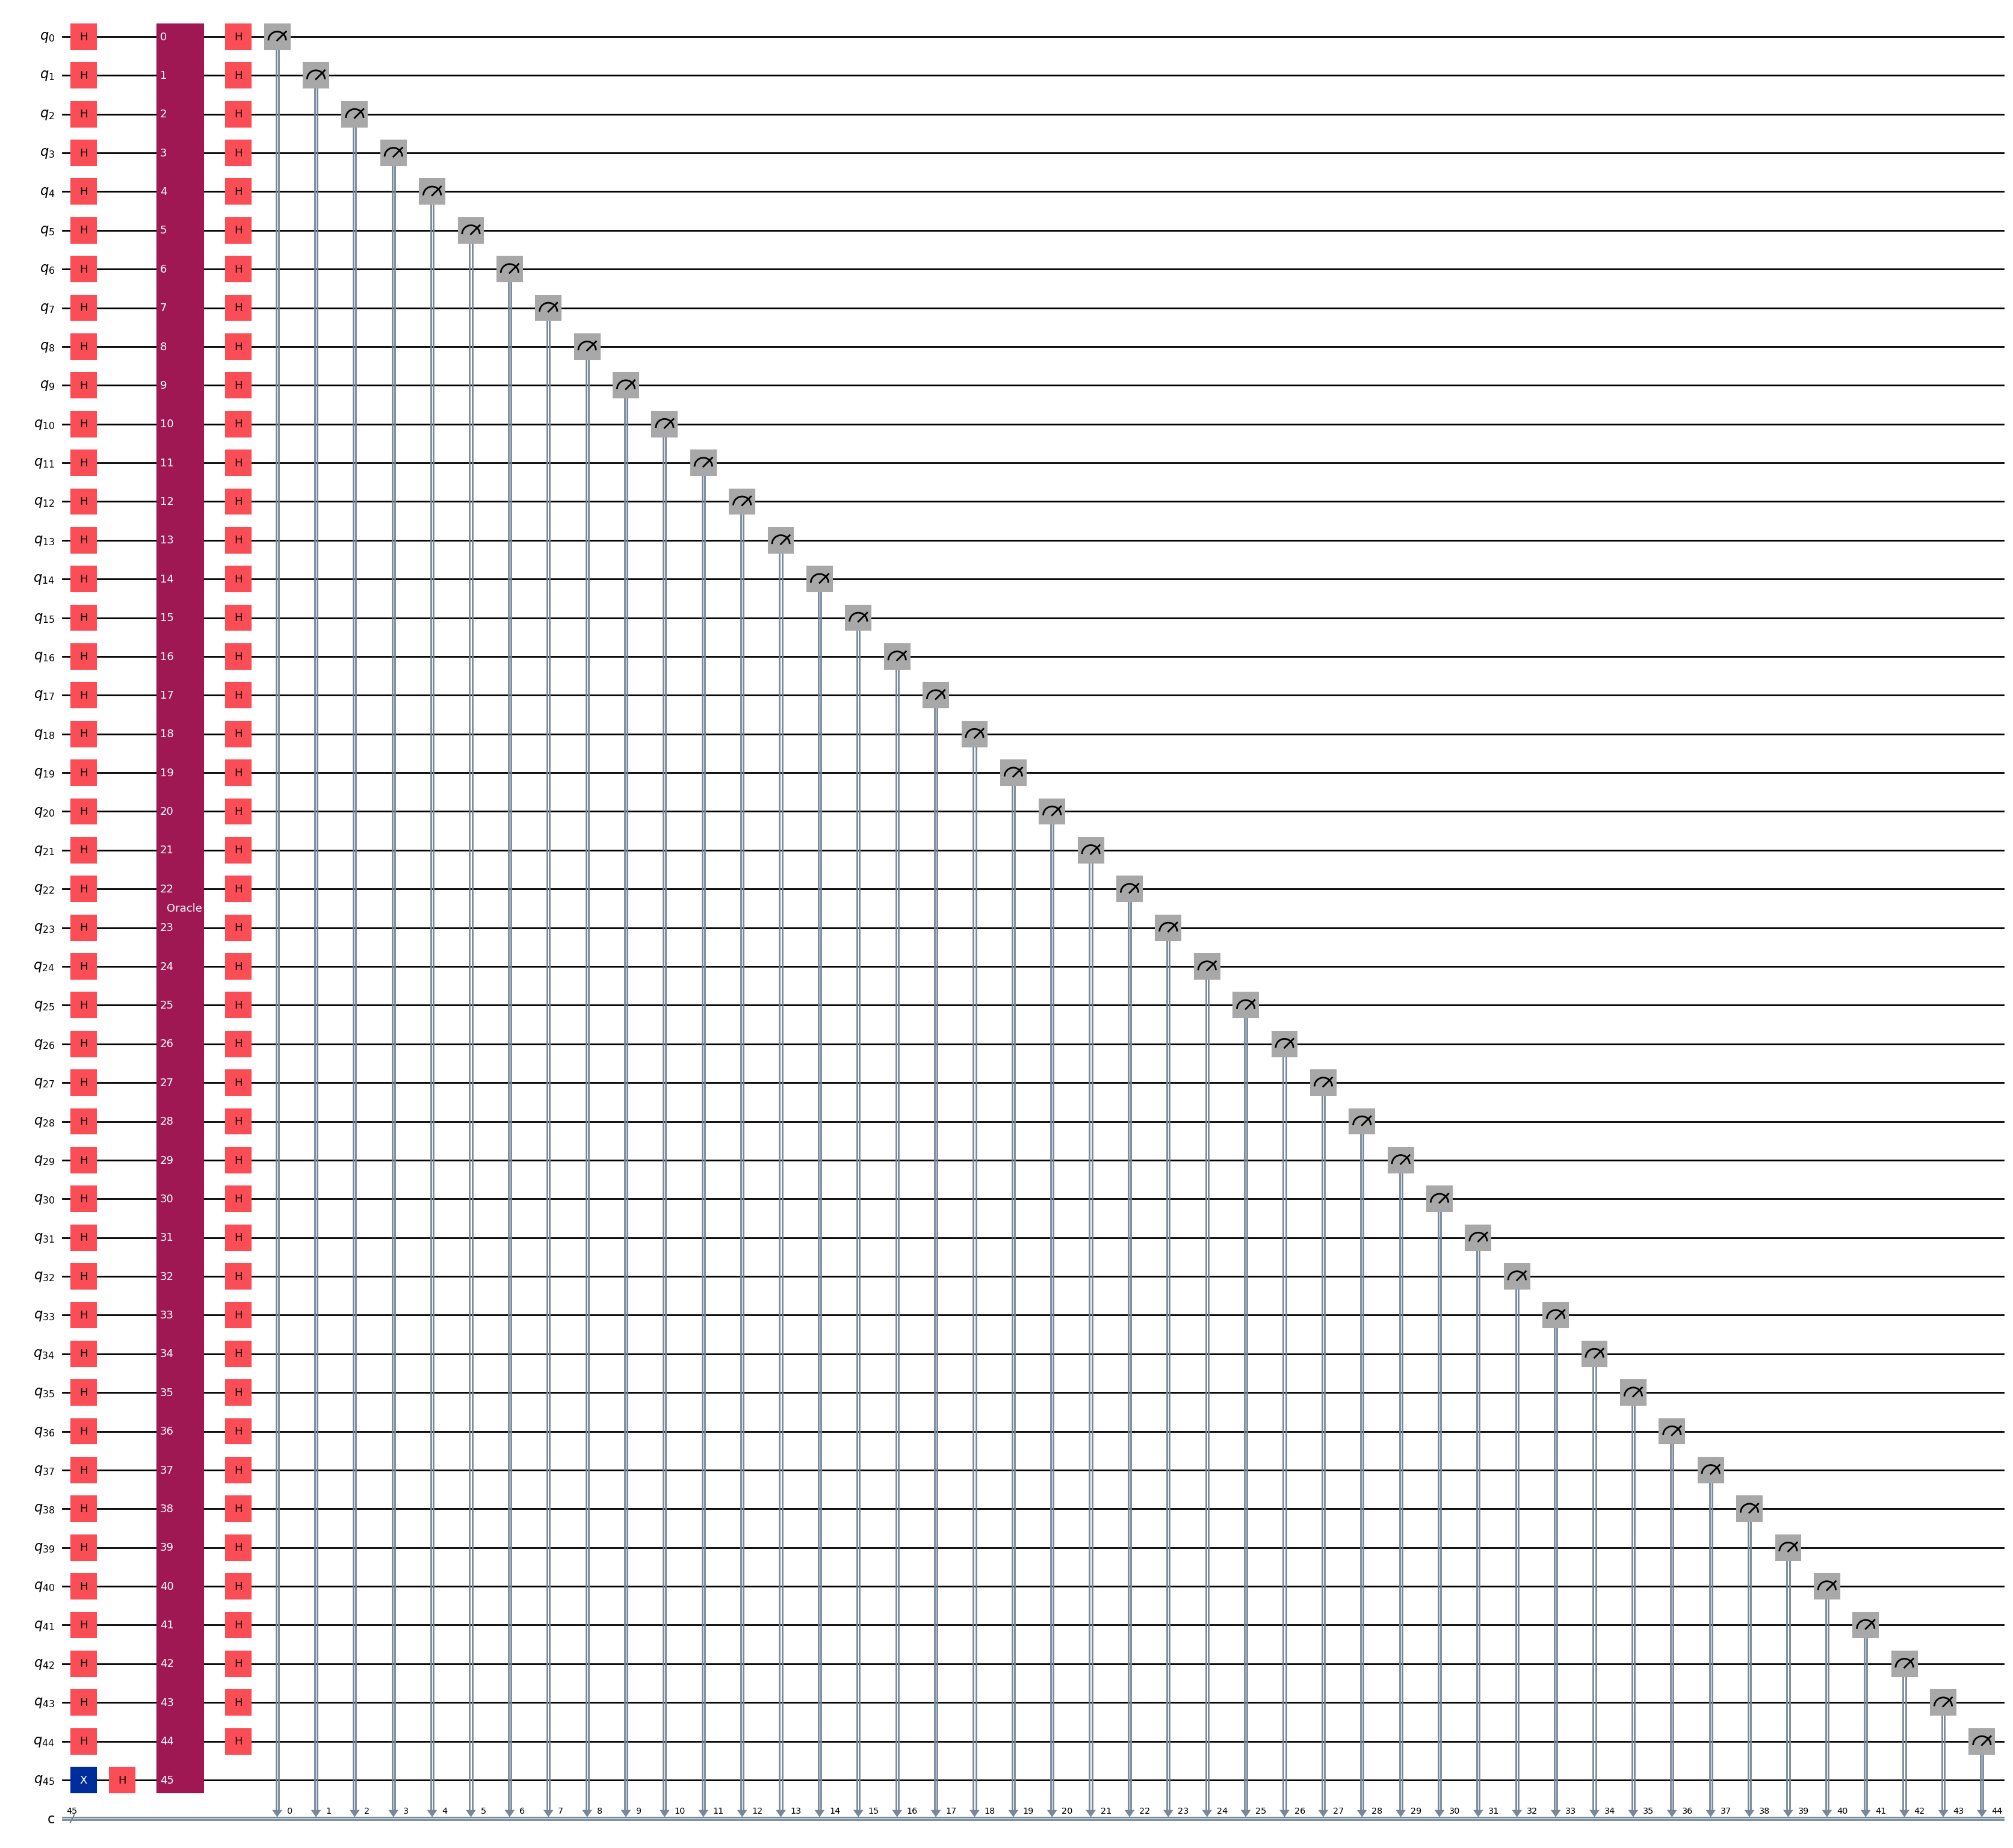

In [49]:
n = 45
oracle_gate = dj_oracle('balanced', n)
dj_circuit = dj_algorithm(oracle_gate, n)
dj_circuit.draw("mpl", fold=-1)

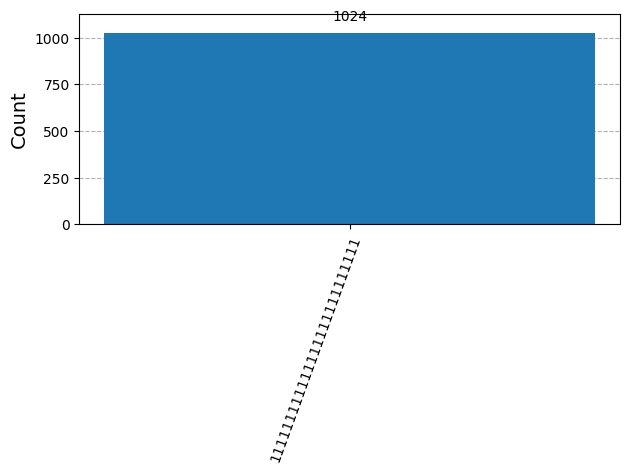

In [38]:
aer_sim = AerSimulator()
transpiled_dj_circuit = transpile(dj_circuit, aer_sim)
results = aer_sim.run(transpiled_dj_circuit).result()
answer = results.get_counts()
plot_histogram(answer)

In [51]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

def run_on_device(qc):
    # Authenticate (replace with your IBM Quantum API token if needed)
    # service = QiskitRuntimeService(channel="ibm_quantum", token="YOUR_API_TOKEN")
    service = QiskitRuntimeService()  # Assumes you are already logged in via qiskit-ibm-provider

    # Choose a backend (real device or simulator)
    # backend = service.backend('ibmq_qasm_simulator')
    backend = service.least_busy(simulator=False, operational=True)
    print(f"Using backend: {backend.name}")

    # Transpile circuit for the backend
    transpiled_qc = transpile(
        qc,
        backend=backend,
        optimization_level=3,
        # layout_method='sabre',
        # routing_method='sabre',
        # seed_transpiler=42
    )
    print("depth:", transpiled_qc.depth(), "CX count:", transpiled_qc.count_ops().get('cx', 0))

    # Submit job using Qiskit Runtime Sampler
    sampler = Sampler(mode=backend)
    job = sampler.run([transpiled_qc], shots=1000)
    result = job.result()
    print("Finished run")
    return result[0].data.c.get_counts()



Using backend: ibm_torino
depth: 344 CX count: 0
Finished run
Max key: 000000000000100000000000000010000000000001011
Count: 2
Probability: 0.0020


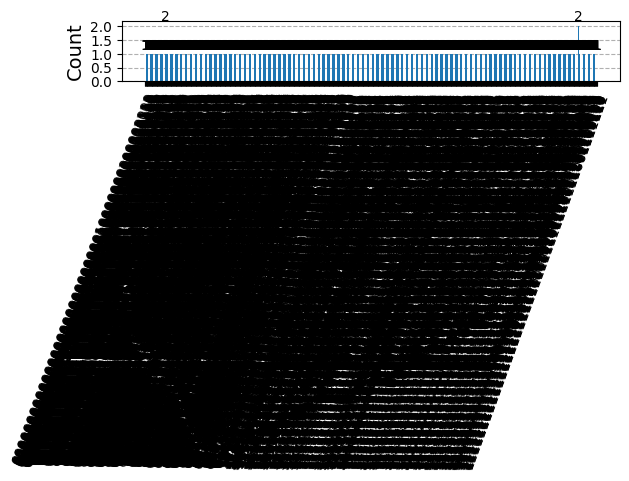

In [52]:
answer = run_on_device(dj_circuit)

max_key = max(answer, key=answer.get)
max_count = answer[max_key]
total_counts = sum(answer.values())
probability = max_count / total_counts
print(f"Max key: {max_key}\nCount: {max_count}\nProbability: {probability:.4f}")

plot_histogram(answer)

Using backend: ibm_torino
depth: 28 CX count: 0
Finished run
Max key: 11111
Count: 847
Probability: 0.8470
Probability of all-1 solution: 0.8470
Using backend: ibm_torino
depth: 132 CX count: 0
Finished run
Max key: 11111111111111111111
Count: 124
Probability: 0.1240
Probability of all-1 solution: 0.1240
Using backend: ibm_torino
depth: 237 CX count: 0
Finished run
Max key: 11111111111111111111111111110111
Count: 7
Probability: 0.0070
Probability of all-1 solution: 0.0040
Using backend: ibm_torino
depth: 363 CX count: 0
Finished run
Max key: 111111111111111111001111111101111101000111010
Count: 1
Probability: 0.0010
Probability of all-1 solution: 0.0000


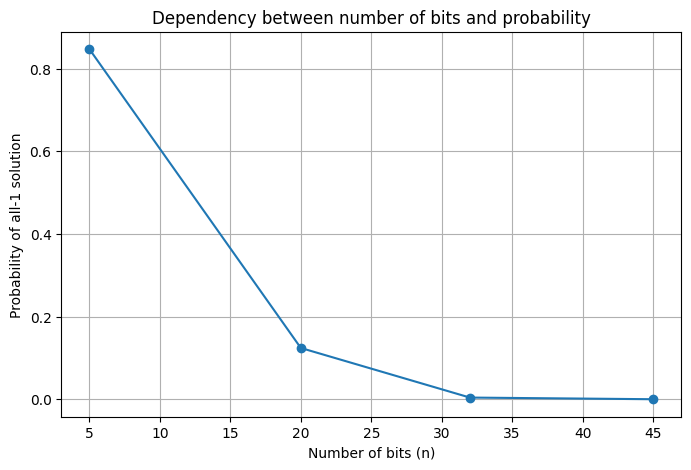

In [54]:
import matplotlib.pyplot as plt

def try_n(n):
    oracle_gate = dj_oracle('balanced', n)
    dj_circuit = dj_algorithm(oracle_gate, n)
    answer = run_on_device(dj_circuit)

    max_key = max(answer, key=answer.get)
    max_count = answer[max_key]
    total_counts = sum(answer.values())
    probability = max_count / total_counts
    print(f"Max key: {max_key}\nCount: {max_count}\nProbability: {probability:.4f}")

    correct_key = '1' * n
    correct_prob = answer.get(correct_key, 0) / total_counts
    print(f"Probability of all-1 solution: {correct_prob:.4f}")
    return correct_prob

probs = {}
for n in [5, 20, 32, 45]:
    probs[n] = try_n(n)
    


plt.figure(figsize=(8, 5))
plt.plot(list(probs.keys()), list(probs.values()), marker='o')
plt.xlabel('Number of bits (n)')
plt.ylabel('Probability of all-1 solution')
plt.title('Dependency between number of bits and probability')
plt.grid(True)
plt.show()